## Document Similarity

This notebook demonstrates how to use Sentence BERT to implement a related posts feature for a website. For convenience, I have hosted all posts from my website in a json file that will be used for this tutorial. 



In [1]:
# !pip install -qq sentence_transformers

In [5]:
import json
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import seaborn as sns

In [7]:
url = 'https://victordibia.com/files/posts.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())
df = pd.DataFrame(data)
df["content"] = df.title + " " + df.description + " " + df.excerpt 
df.head(2)

,id,title,description,slug,excerpt,published,date,image,content
0,500ca553-04ea-5134-ba2d-6e07c2884b24,How to Build a Similar Posts Index for Your Ga...,"Extract representations for each post, compute...",/blog/document-similarity/,TLDR; Step 1: Export the text for each post in...,True,January 6th 2023,blog/docsim.png,How to Build a Similar Posts Index for Your Ga...
1,08494153-f9a7-5eb1-9a20-466e009c4ada,2022 Year in Review,Got some stuff done.,/blog/year-in-review-2022/,2022 has been a fairly interesting year! Octob...,True,December 31st 2022,blog/yir2022.png,2022 Year in Review Got some stuff done. 2022 ...


In [9]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
bert_model = SentenceTransformer('bert-base-uncased')

No sentence-transformers model found with name /Users/victordibia/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/victordibia/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassific

In [10]:
def get_score_map(sentences, model, n=10):
  embeddings = model.encode(sentences, convert_to_tensor=True)
  cosine_scores = util.cos_sim(embeddings, embeddings) 
  
  score_map = {}
  for i in range(cosine_scores.shape[0]):
    holder = []
    for j in range(cosine_scores.shape[1]):
      if i != j:
        holder.append({ "id": df.id[j], "image": df.image[j], "title": df.title[j], "score": float(cosine_scores[i][j].cpu().numpy()),  "slug": df.slug[j]})
    holder = sorted(holder, key=lambda x: x['score'], reverse=True)
    score_map[df.slug[i]] = holder[:n]
  return score_map, cosine_scores.cpu().numpy()

In [11]:
sbert_scoremap, sbert_scores = get_score_map(df.content, sbert_model)
bert_scoremap, bert_scores = get_score_map(df.content, bert_model)

In [12]:
sbert_scoremap["/blog/explain-bert-qa/"][:5]

[{'id': 'dfc72499-a596-51fa-86f1-6e01dbd5a74a',
  'image': 'blog/explainberthf.png',
  'title': 'How to Implement Gradient Explanations for a HuggingFace Text Classification Model (Tensorflow 2.0)',
  'score': 0.7560314536094666,
  'slug': '/blog/explain-bert-classification/'},
 {'id': 'bdc99bc2-d9cd-5a62-b56a-816014559d34',
  'image': 'blog/og-card.png',
  'title': 'How to Implement Extractive Summarization with BERT in Pytorch',
  'score': 0.6393120288848877,
  'slug': '/blog/extractive-summarization-pytorch/'},
 {'id': '15a3af71-ca63-5731-997a-63f6ca36b582',
  'image': 'blog/ml.jpg',
  'title': 'How to Finetune BERT for Text Classification (HuggingFace Transformers, Tensorflow 2.0) on a Custom Dataset',
  'score': 0.5659793019294739,
  'slug': '/blog/text-classification-hf-tf2/'},
 {'id': '4cba37c9-212f-54b5-abc4-33eeabb01883',
  'image': 'blog/og-card.png',
  'title': 'Neural Extractive Summarization with BERT',
  'score': 0.5180303454399109,
  'slug': '/blog/extractive-summarizati

In [13]:
bert_scoremap["/blog/explain-bert-qa/"][:5]

[{'id': 'dfc72499-a596-51fa-86f1-6e01dbd5a74a',
  'image': 'blog/explainberthf.png',
  'title': 'How to Implement Gradient Explanations for a HuggingFace Text Classification Model (Tensorflow 2.0)',
  'score': 0.9652143716812134,
  'slug': '/blog/explain-bert-classification/'},
 {'id': '986f46ae-700a-5ef7-86ae-812ea62e3592',
  'image': 'blog/og-object-detection.jpg',
  'title': 'State of Deep Learning for Object Detection - You Should Consider CenterNets!',
  'score': 0.9606658220291138,
  'slug': '/blog/state-of-object-detection/'},
 {'id': 'f86ac039-62fe-553c-9226-c09fd4c02f8a',
  'image': 'blog/og-card.png',
  'title': 'U2Net Going Deeper with Nested U-Structure for Salient Object Detection | Paper Review',
  'score': 0.9602547883987427,
  'slug': '/blog/u-2-net/'},
 {'id': 'bb654451-accb-55f2-b8de-16949f594bab',
  'image': 'blog/og-card.png',
  'title': 'Introducing Anomagram - An Interactive Visualization of Autoencoders, Built with Tensorflow.js',
  'score': 0.9601619243621826,
 

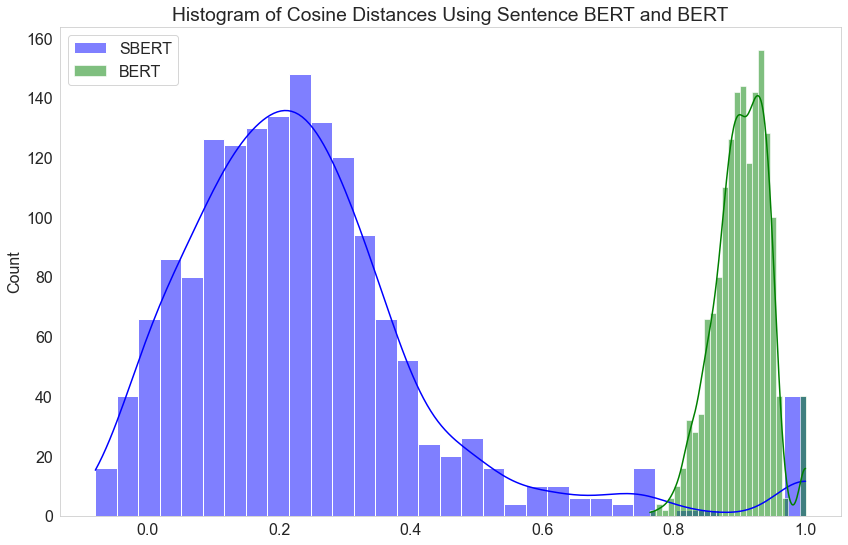

In [15]:
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)


sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(14,9))
sns.histplot(sbert_scores.flatten(), kde=True, color="blue", label="SBERT");
sns.histplot(bert_scores.flatten(), kde=True, color="green", label="BERT");
plt.legend();
plt.title(f"Histogram of Cosine Distances Using Sentence BERT and BERT");



In [11]:
import json
with open('similar.json', 'w') as fp:
    json.dump(sbert_scoremap, fp)